In [5]:
import pandas as pd
data = pd.read_csv('./Data/train.csv')
test_data = pd.read_csv('./Data/test.csv')
print (data.shape)
print (test_data.shape)
data.head()

(5500, 23)
(5952, 22)


,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [7]:
import seaborn as sns
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
corr = data.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
Choice,1,0.13,0.064,0.14,0.021,0.024,0.12,0.14,0.11,0.066,0.074,0.085,-0.16,-0.043,-0.19,-0.062,-0.065,-0.14,-0.17,-0.1,-0.11,-0.051,-0.069
A_follower_count,0.13,1,0.12,0.82,0.51,0.52,0.018,0.095,0.043,0.62,-0.15,-0.036,0.16,0.033,0.14,0.029,0.031,-0.012,-0.011,-0.013,0.052,-0.034,-0.014
A_following_count,0.064,0.12,1,0.1,0.058,0.052,0.11,-0.084,0.14,0.047,0.044,0.098,-0.0076,-0.011,-0.012,0.0011,-0.0018,0.0068,0.0022,-0.00028,-0.0025,0.0034,-0.004
A_listed_count,0.14,0.82,0.1,1,0.73,0.75,0.062,0.16,0.054,0.71,-0.08,-0.039,0.21,0.049,0.2,0.046,0.045,-0.0028,0.006,0.0035,0.068,-0.035,-0.01
A_mentions_received,0.021,0.51,0.058,0.73,1,0.99,0.023,0.05,0.027,0.92,-0.062,-0.038,0.15,0.023,0.14,0.011,0.0081,-0.0087,-0.012,-0.011,0.023,-0.018,-0.011
A_retweets_received,0.024,0.52,0.052,0.75,0.99,1,0.019,0.044,0.033,0.93,-0.065,-0.04,0.15,0.023,0.14,0.012,0.0087,-0.0072,-0.013,-0.0097,0.024,-0.018,-0.013
A_mentions_sent,0.12,0.018,0.11,0.062,0.023,0.019,1,0.58,0.61,0.033,0.064,0.035,-0.0057,0.028,0.0054,0.0065,0.011,0.017,0.0036,0.019,0.0052,0.016,0.014
A_retweets_sent,0.14,0.095,-0.084,0.16,0.05,0.044,0.58,1,0.38,0.082,-0.049,-0.042,0.025,0.016,0.038,0.058,0.06,0.029,0.012,0.039,0.051,-0.0046,0.006
A_posts,0.11,0.043,0.14,0.054,0.027,0.033,0.61,0.38,1,0.075,-0.066,-0.018,-0.012,0.022,-0.0053,0.0018,0.006,0.028,0.0021,0.024,-0.0019,0.011,0.0047
A_network_feature_1,0.066,0.62,0.047,0.71,0.92,0.93,0.033,0.082,0.075,1,-0.12,-0.072,0.14,0.035,0.13,0.012,0.011,-0.0028,-0.013,-0.01,0.026,-0.024,-0.015


## Feature Engineering

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
import numpy as np

y = data.iloc[:,0]
A_features = data.iloc[:,1:12]
B_features = data.iloc[:,12:]
column_names = [name[2:] for name in A_features.columns]
A_features.columns = column_names
B_features.columns = column_names

def transform_features(x):
    return np.log(1+x)
X = transform_features(A_features) - transform_features(B_features)

##  Remove collinearity

In [9]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

X = corr_df(X,0.6)

listed_count | follower_count | 0.93
mentions_received | follower_count | 0.85
retweets_received | follower_count | 0.82
retweets_received | listed_count | 0.79
posts | mentions_received | 0.62
posts | retweets_received | 0.62
posts | mentions_sent | 0.82
network_feature_1 | follower_count | 0.87
network_feature_1 | listed_count | 0.86
network_feature_1 | mentions_received | 0.99
network_feature_1 | retweets_received | 0.95


In [10]:
corr = X.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,follower_count,following_count,mentions_sent,retweets_sent,network_feature_2,network_feature_3
follower_count,1,0.3,0.38,0.32,0.19,0.42
following_count,0.3,1,0.17,0.0056,0.3,0.29
mentions_sent,0.38,0.17,1,0.7,0.3,0.33
retweets_sent,0.32,0.0056,0.7,1,0.12,0.19
network_feature_2,0.19,0.3,0.3,0.12,1,0.85
network_feature_3,0.42,0.29,0.33,0.19,0.85,1


## Logistic Regression

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = linear_model.LogisticRegression()
model.fit(X_train,y_train)

# compute AuC score on the training data (BTW this is kind of useless due to overfitting, but hey, this is only an example solution)
p_train = model.predict_proba(X_train)
c_train = model.predict(X_train)
p_train = p_train[:,1:2]
# print ('AuC score on training data for logistic:',roc_auc_score(y_train,p_train))
# print ('Accuracy score on training data for logistic:',accuracy_score(y_train,c_train))

p_test = model.predict_proba(X_test)
c_test = model.predict(X_test)
p_test = p_test[:,1:2]
print ('AuC score on test data for logistic:',round(roc_auc_score(y_test,p_test),2))
print ('Accuracy score on test data for logistic:',round(accuracy_score(y_test,c_test),2))
print ('R2 for logistic:',round(r2_score(y_test,c_test),2))

AuC score on test data for logistic: 0.85
Accuracy score on test data for logistic: 0.74
R2 for logistic: -0.02


C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
print(model.coef_)

[[ 0.42042948  0.13716165  0.23314648  0.28703078 -0.11762118]]


In [14]:
print(model.intercept_)

[0.03522275]


## Feature selection Logistic

In [12]:
from sklearn.feature_selection import RFE

#To select 3 features
rfe = RFE(model, 5)
rfe = rfe.fit(X_train, y_train.values.ravel())

selected_cols = X_train.columns.values[rfe.support_] #get selcted columns using support for columns from rfe
X_train_rfe = X_train.loc[:,selected_cols]
y_train_rfe = y_train
X_test_rfe = X_test.loc[:,selected_cols]

model.fit(X_train_rfe, y_train_rfe) #fir log_cv on selected columns
y_pred_RFE = model.predict(X_train_rfe)
y_test_RFE = model.predict(X_test_rfe)
# print (pd.crosstab(y_train_rfe, y_pred_RFE, rownames=['True'], colnames=['Predicted'], margins=True))
print ("accuracy on train =", round(accuracy_score(y_train_rfe, y_pred_RFE),2))

# print (pd.crosstab(y_test, y_test_RFE, rownames=['True'], colnames=['Predicted'], margins=True))
print ("accuracy on test =", round(accuracy_score(y_test, y_test_RFE),2))

coefficients = pd.concat([pd.DataFrame(X_train_rfe.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print (coefficients)
import sklearn
sklearn.metrics.r2_score(y_test_RFE,c_test)

accuracy on train = 0.77
accuracy on test = 0.75
                   0         0
0     follower_count  0.420429
1      mentions_sent  0.137162
2      retweets_sent  0.233146
3  network_feature_2  0.287031
4  network_feature_3 -0.117621


0.9672722945096794

## Feature Importance RF

AuC score on test data for Random Forest: 0.84
Accuracy score on test data for Random Forest: 0.74
R2: -0.04137702747434635


Text(0.5,0,'Relative Importance')

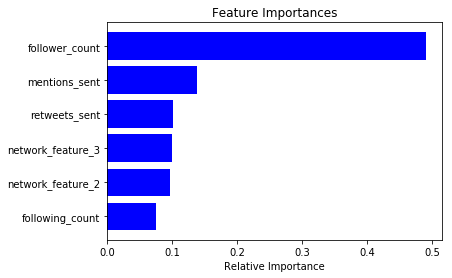

In [8]:
from sklearn.feature_selection import RFECV

rf_model = RandomForestClassifier(n_estimators=50,max_depth = 10)
rfecv = RFECV(estimator=rf_model, step=5, cv=2, scoring='r2', verbose=-1)
rfecv.fit(X_train, y_train)
rf_model.fit(X_train,y_train)

# compute AuC score on the training data (BTW this is kind of useless due to overfitting, but hey, this is only an example solution)
p_train = rfecv.predict_proba(X_train)
c_train = rfecv.predict(X_train)
p_train = p_train[:,1:2]
# print ('AuC score on training data for Random Forest:',roc_auc_score(y_train,p_train))
# print ('Accuracy score on training data for Random Forest:',accuracy_score(y_train,c_train))

p_test = rfecv.predict_proba(X_test)
c_test = rfecv.predict(X_test)
p_test = p_test[:,1:2]
print ('AuC score on test data for Random Forest:',round(roc_auc_score(y_test,p_test),2))
print ('Accuracy score on test data for Random Forest:',round(accuracy_score(y_test,c_test),2))
print ('R2:', sklearn.metrics.r2_score(y_test,c_test))
features=X_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

import matplotlib.pyplot as plt
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

## GBM

In [9]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, d_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(d_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, d_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(y_test, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns.values).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

C:\Users\teeru\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\teeru\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
## Tuning
param_test2 = {'max_depth':list(range(2,6,1)), 'min_samples_split':list(range(60,300,20))}
# param_test1 = {'n_estimators':list(range(80,150,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 130
                                                               ,min_samples_leaf=50,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85456, std: 0.01332, params: {'max_depth': 2, 'min_samples_split': 60},
  mean: 0.85456, std: 0.01332, params: {'max_depth': 2, 'min_samples_split': 80},
  mean: 0.85456, std: 0.01332, params: {'max_depth': 2, 'min_samples_split': 100},
  mean: 0.85455, std: 0.01334, params: {'max_depth': 2, 'min_samples_split': 120},
  mean: 0.85448, std: 0.01333, params: {'max_depth': 2, 'min_samples_split': 140},
  mean: 0.85445, std: 0.01297, params: {'max_depth': 2, 'min_samples_split': 160},
  mean: 0.85428, std: 0.01314, params: {'max_depth': 2, 'min_samples_split': 180},
  mean: 0.85436, std: 0.01292, params: {'max_depth': 2, 'min_samples_split': 200},
  mean: 0.85458, std: 0.01290, params: {'max_depth': 2, 'min_samples_split': 220},
  mean: 0.85461, std: 0.01276, params: {'max_depth': 2, 'min_samples_split': 240},
  mean: 0.85415, std: 0.01251, params: {'max_depth': 2, 'min_samples_split': 260},
  mean: 0.85434, std: 0.01261, params: {'max_depth': 2, 'min_samples_split': 280},
  mean


Model Report
Accuracy : 0.7373
AUC Score (Train): 0.842476
CV Score : Mean - 0.8542537 | Std - 0.01310675 | Min - 0.8369391 | Max - 0.8701018


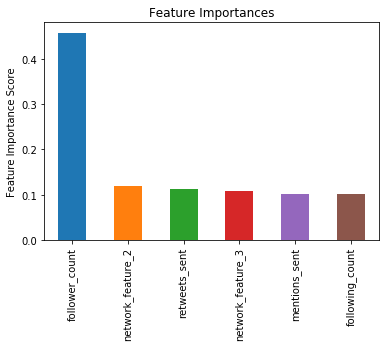

In [11]:
gbm0 = GradientBoostingClassifier(learning_rate=0.05,n_estimators=130, min_samples_split=200,min_samples_leaf=50,max_depth=3
                                  ,max_features='sqrt',subsample=0.8,random_state=10)
modelfit(gbm0, X_train)

## Predict on submission file

In [12]:
submission = pd.read_csv('C:/Users/teeru/Downloads/predict-who-is-more-influential-in-a-social-network/sample_predictions.csv')

A_features = test_data.iloc[:,0:11]
B_features = test_data.iloc[:,11:]
A_features.columns = column_names
B_features.columns = column_names

def transform_features(x):
    return np.log(1+x)
X_sub = transform_features(A_features) - transform_features(B_features)

In [13]:
# For Rfecv
X_sub = X_sub.loc[:,selected_cols]

test_pred = model.predict_proba(X_sub)
test_pred[:,1:2]

submission=pd.DataFrame()
submission['Id'] = pd.Series(range(1,len(test_data)+1))
submission['Choice'] = pd.Series(test_pred[:,1:2].ravel())

submission.to_csv('C:/Users/teeru/Downloads/submission.csv',index=False)

## Based on the performance of the above models, we chose to go ahead witht the RFE logistic regression and use that for lift calculation

In [14]:
# Confusion Matrix of the RFE model
from sklearn.metrics import confusion_matrix
print(pd.DataFrame(confusion_matrix(y_test, y_test_RFE, labels=[0, 1]), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))

        pred:0  pred:1
true:0     401     129
true:1     147     423


C:\Users\teeru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


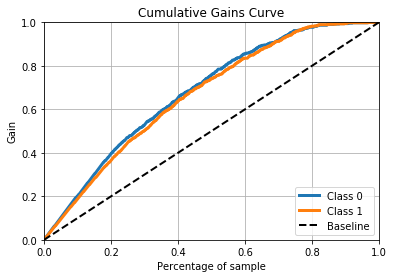

In [15]:
import matplotlib.pyplot as plt
import scikitplot as skplt
p_pred_RFE = model.predict_proba(X_test_rfe)
skplt.metrics.plot_cumulative_gain(y_test,p_pred_RFE)

In [16]:
pred_choice = pd.DataFrame(data = y_test_RFE, index = X_test_rfe.index, columns = ['Pred_Choice'])
X_fin = data
X_fin =  X_fin[X_fin.index.isin(X_test_rfe.index)]
X_fin['Pred_Choice'] = pred_choice['Pred_Choice']
X_fin = X_fin[['Choice', 'A_follower_count','B_follower_count','Pred_Choice']]

C:\Users\teeru\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
X_fin['products_sold_without_analytics'] = np.where(X_fin['Choice'] == 1, 0.0001*X_fin['A_follower_count'], 
                                                    0.0001*X_fin['B_follower_count'])
X_fin['products_sold_with_analytics'] = np.where(X_fin['Pred_Choice'] == 1, 0.00015*X_fin['A_follower_count'], 
                                                 0.00015*X_fin['B_follower_count'])
X_fin['products_sold_with_perfect_analytics'] = np.where(X_fin['Choice'] == 1, 0.00015*X_fin['A_follower_count'], 
                                                         0.00015*X_fin['B_follower_count'])

In [18]:
cost_without = 5*2200
cost_with = 10*1100
margin_without = 10*sum(X_fin['products_sold_without_analytics'])
margin_with = 10*sum(X_fin['products_sold_with_analytics'])
margin_with_perfect = 10*sum(X_fin['products_sold_with_perfect_analytics'])
profit_without  = margin_without - cost_without
profit_with  = margin_with - cost_with
profit_with_perfect  = margin_with_perfect - cost_with
lift_with = round(100*(profit_with-profit_without)/profit_without,2)
lift_with_perfect = round(100*(profit_with_perfect-profit_without)/profit_without,2)

# Lift calculation

In [19]:
profit =[margin_without, margin_with, margin_with_perfect]
cost = [cost_without, cost_with, cost_with]
idx = ['Without Analytics','With Analytics','With Perfect Analytics']
lift_df = pd.DataFrame(columns = ['Profit', 'Cost'], index = idx)
lift_df['Profit'] = profit
lift_df['Cost'] = cost
print(lift_df)
print("")
print('Lift in expected net profit from using the analytical model is',lift_with,'%' )
print('Lift in net profit with a perfect analytical model is',lift_with_perfect,'%')

                              Profit   Cost
Without Analytics       1.140507e+06  11000
With Analytics          2.093883e+06  11000
With Perfect Analytics  1.710761e+06  11000

Lift in expected net profit from using the analytical model is 84.41 %
Lift in net profit with a perfect analytical model is 50.49 %


# % increase chart

In [20]:
cum_without = np.cumsum(X_fin['products_sold_without_analytics'].sort_values())
cum_with = np.cumsum(X_fin['products_sold_with_analytics'].sort_values())
lift_plot_without = pd.DataFrame(cum_without)
lift_plot_without['%cum'] = lift_plot_without['products_sold_without_analytics']/sum(lift_plot_without['products_sold_without_analytics'])
lift_plot_with = pd.DataFrame(cum_with)
lift_plot_with['%cum'] = lift_plot_with['products_sold_with_analytics']/sum(lift_plot_with['products_sold_with_analytics'])
lift_plot_with.set_index('%cum', inplace = True)
lift_plot_without.set_index('%cum', inplace = True)

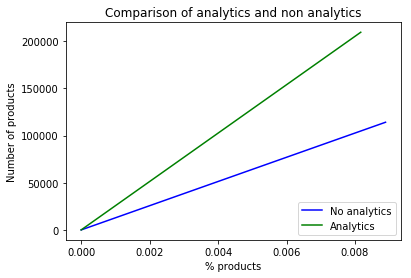

In [21]:
plt.plot(lift_plot_without, c='blue')
plt.plot(lift_plot_with, c='green')
plt.xlabel('% products')
plt.ylabel('Number of products')
plt.title('Comparison of analytics and non analytics')
plt.legend(('No analytics','Analytics'),loc='lower right')